In [1]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pymortar
import logging 
import os
import json

from get_test_days import get_test_data
from feature_engineering import get_time_of_week, get_t_cutoff_values
from utils import get_window_of_day, get_workdays, get_closest_station, mean_absolute_percentage_error
from daily_data import get_daily_data
import get_data as gd


DEBUG:matplotlib:CACHEDIR=/Users/jleyden/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/jleyden/.matplotlib/fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [20]:
start_train = "2016-01-01T00:00:00Z"
end_train = "2019-05-01T00:00:00Z"
site = "ciee"

exclude_only_2018 = False
dr_event_dates = [
        "2017-06-16",
        "2017-06-19",
        "2017-06-20",
        "2017-06-22",
        "2017-06-23",
        "2017-07-07",
        "2017-07-27",
        "2017-07-31",
        "2017-08-01",
        "2017-08-02",
        "2017-08-28",
        "2017-08-29",
        "2017-08-31",
        "2017-09-01",
        "2017-09-02",
        "2017-06-19",
        "2017-06-20",
        "2017-07-06",
        "2017-07-07",
        "2017-07-27",
        "2017-07-31",
        "2017-08-01",
        "2017-08-28",
        "2017-08-29",
        "2017-08-31",
        "2017-09-05",
        "2017-09-12",
        "2018-06-12",
        "2018-06-13",
        "2018-07-10",
        "2018-07-16",
        "2018-07-17",
        "2018-07-19",
        "2018-07-24",
        "2018-07-25",
        "2018-07-27"
    ]

client = pymortar.Client()
cli = pymortar.Client()

dr_event_dates = [pd.to_datetime(d).date() for d in dr_event_dates]


# Get days that are similar to DR-event days to test the regression model on
test_days, train_days = get_test_data(site, dr_event_dates, start_train, end_train, cli=client)


# train baseline model on days exlcuding event days and our test set
exclude_dates = np.concatenate((test_days, dr_event_dates))

if exclude_only_2018:
    dr_exclude = [d for d in dr_event_dates if d.year == 2018]
    exclude_dates = np.concatenate((test_days, dr_exclude))

"""
Fit the regression model for a site during for the specified window
exclude_dates is a an optional set of datetime.date objects to exclude from training
cli: pymortar client
"""
start = start_train
end = end_train
interval = '15min'
agg = 'RAW'
alphas = [0.0001, .001, 0.01, 0.05, 0.1, 0.5, 1, 10]

# Get weather
weather = gd.get_weather(site, start, end, agg=agg, window=interval, cli=cli)
weather.index = weather.index.tz_localize('UTC').tz_convert('US/Pacific')
closest_station = get_closest_station(site)
if closest_station is not None:
    weather = pd.DataFrame(weather[closest_station])
else:
    weather = pd.DataFrame(weather.mean(axis=1))
weather.interpolate()    

# Get power
power = gd.get_power(site, start, end, agg=agg, window=interval, cli=cli) * 4
power.index = power.index.tz_localize('UTC').tz_convert('US/Pacific')

# Merge
weather_mean = pd.DataFrame(weather.mean(axis=1))
power_sum = pd.DataFrame(power.sum(axis=1))
data = power_sum.merge(weather_mean, left_index=True, right_index=True)
data.columns = ['power', 'weather']

# Get weekdays
data['date'] = data.index.date
weekdays = get_workdays(start, end)
day_filter = [d in weekdays for d in data['date']]
df = data[day_filter]

# Exclude dates
day_filter = [d not in exclude_dates for d in df.index.date]
#df = df[day_filter]

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


In [22]:
df = df.dropna()

In [23]:
df = df[df['power'] != 0]

In [24]:
def time_of_year(ts):
    delta = ts - pd.to_datetime(ts.year.astype(str)).tz_localize(ts.tz)
    return delta.total_seconds()

In [25]:
def time_of_week(ts):
    return 60*60*24 * ts.dayofweek + 60*60 * ts.hour + 60*ts.minute

In [26]:
def time_of_day(ts):
    delta = ts - pd.to_datetime(ts.date).tz_localize(ts.tz)
    return delta.total_seconds()

In [27]:
df['time_of_year'] = time_of_year(df.index)

In [28]:
df['time_of_week'] = time_of_week(df.index)

In [29]:
df['time_of_day'] = time_of_day(df.index)

In [30]:
df.head()

,power,weather,date,time_of_year,time_of_week,time_of_day
2016-01-13 02:15:00-08:00,1920.0,53.6,2016-01-13,1044900.0,180900,8100.0
2016-01-19 08:45:00-08:00,6032.0,55.4,2016-01-19,1586700.0,117900,31500.0
2016-01-25 10:15:00-08:00,5904.0,55.4,2016-01-25,2110500.0,36900,36900.0
2016-01-26 09:15:00-08:00,7248.0,51.8,2016-01-26,2193300.0,119700,33300.0
2016-01-29 12:30:00-08:00,7072.0,60.8,2016-01-29,2464200.0,390600,45000.0


In [53]:
date = df.index[-5]
df['power'].index

DatetimeIndex(['2016-01-13 02:15:00-08:00', '2016-01-19 08:45:00-08:00',
               '2016-01-25 10:15:00-08:00', '2016-01-26 09:15:00-08:00',
               '2016-01-29 12:30:00-08:00', '2016-01-29 16:45:00-08:00',
               '2016-01-29 23:15:00-08:00', '2016-02-17 11:45:00-08:00',
               '2016-02-17 19:15:00-08:00', '2016-02-29 08:45:00-08:00',
               ...
               '2018-11-29 21:30:00-08:00', '2018-11-29 21:45:00-08:00',
               '2018-11-29 22:00:00-08:00', '2018-11-29 22:15:00-08:00',
               '2018-11-29 22:30:00-08:00', '2018-11-29 22:45:00-08:00',
               '2018-11-29 23:00:00-08:00', '2018-11-29 23:15:00-08:00',
               '2018-11-29 23:30:00-08:00', '2018-11-29 23:45:00-08:00'],
              dtype='datetime64[ns, US/Pacific]', length=43457, freq=None)

In [75]:
def subtract_days(date, num):
    return date - pd.to_timedelta('{}d'.format(num))

In [86]:
last_days = [subtract_days(d, 1) for d in dates]

In [98]:
last_days_set = set(last_days)
dates_set = set(dates)
len(last_days_set.intersection(dates_set))

32436

In [111]:
last_date_copy = last_days.copy()
for i in range(len(last_days)):
    last_date = last_date_copy[i]
    if last_date not in dates_set:
        for j in range(1, 7):
            new_last_date = subtract_days(last_date, j)
            if new_last_date in dates_set:
                last_date_copy[i] = new_last_date
                print("succesfully replaced {} with {}".format(last_date, new_last_date))
                break
            last_date_copy[i] = None

succesfully replaced 2016-07-04 00:00:00-07:00 with 2016-07-01 00:00:00-07:00
succesfully replaced 2016-07-04 00:15:00-07:00 with 2016-07-01 00:15:00-07:00
succesfully replaced 2016-07-04 00:30:00-07:00 with 2016-07-01 00:30:00-07:00
succesfully replaced 2016-07-04 00:45:00-07:00 with 2016-07-01 00:45:00-07:00
succesfully replaced 2016-07-04 01:00:00-07:00 with 2016-07-01 01:00:00-07:00
succesfully replaced 2016-07-04 01:15:00-07:00 with 2016-07-01 01:15:00-07:00
succesfully replaced 2016-07-04 01:30:00-07:00 with 2016-07-01 01:30:00-07:00
succesfully replaced 2016-07-04 01:45:00-07:00 with 2016-07-01 01:45:00-07:00
succesfully replaced 2016-07-04 02:00:00-07:00 with 2016-07-01 02:00:00-07:00
succesfully replaced 2016-07-04 02:15:00-07:00 with 2016-07-01 02:15:00-07:00
succesfully replaced 2016-07-04 02:30:00-07:00 with 2016-07-01 02:30:00-07:00
succesfully replaced 2016-07-04 02:45:00-07:00 with 2016-07-01 02:45:00-07:00
succesfully replaced 2016-07-04 03:00:00-07:00 with 2016-07-01 0

succesfully replaced 2016-07-31 11:15:00-07:00 with 2016-07-29 11:15:00-07:00
succesfully replaced 2016-07-31 11:30:00-07:00 with 2016-07-29 11:30:00-07:00
succesfully replaced 2016-07-31 11:45:00-07:00 with 2016-07-29 11:45:00-07:00
succesfully replaced 2016-07-31 12:00:00-07:00 with 2016-07-29 12:00:00-07:00
succesfully replaced 2016-07-31 12:15:00-07:00 with 2016-07-29 12:15:00-07:00
succesfully replaced 2016-07-31 12:30:00-07:00 with 2016-07-29 12:30:00-07:00
succesfully replaced 2016-07-31 12:45:00-07:00 with 2016-07-29 12:45:00-07:00
succesfully replaced 2016-07-31 13:00:00-07:00 with 2016-07-29 13:00:00-07:00
succesfully replaced 2016-07-31 13:15:00-07:00 with 2016-07-29 13:15:00-07:00
succesfully replaced 2016-07-31 13:30:00-07:00 with 2016-07-29 13:30:00-07:00
succesfully replaced 2016-07-31 13:45:00-07:00 with 2016-07-28 13:45:00-07:00
succesfully replaced 2016-07-31 14:00:00-07:00 with 2016-07-29 14:00:00-07:00
succesfully replaced 2016-07-31 14:15:00-07:00 with 2016-07-29 1

succesfully replaced 2016-08-28 12:45:00-07:00 with 2016-08-26 12:45:00-07:00
succesfully replaced 2016-08-28 13:00:00-07:00 with 2016-08-26 13:00:00-07:00
succesfully replaced 2016-08-28 13:15:00-07:00 with 2016-08-26 13:15:00-07:00
succesfully replaced 2016-08-28 13:30:00-07:00 with 2016-08-26 13:30:00-07:00
succesfully replaced 2016-08-28 13:45:00-07:00 with 2016-08-26 13:45:00-07:00
succesfully replaced 2016-08-28 14:00:00-07:00 with 2016-08-26 14:00:00-07:00
succesfully replaced 2016-08-28 14:15:00-07:00 with 2016-08-26 14:15:00-07:00
succesfully replaced 2016-08-28 14:30:00-07:00 with 2016-08-26 14:30:00-07:00
succesfully replaced 2016-08-28 14:45:00-07:00 with 2016-08-26 14:45:00-07:00
succesfully replaced 2016-08-28 15:00:00-07:00 with 2016-08-25 15:00:00-07:00
succesfully replaced 2016-08-28 15:15:00-07:00 with 2016-08-26 15:15:00-07:00
succesfully replaced 2016-08-28 15:30:00-07:00 with 2016-08-26 15:30:00-07:00
succesfully replaced 2016-08-28 15:45:00-07:00 with 2016-08-26 1

succesfully replaced 2016-10-02 23:30:00-07:00 with 2016-09-30 23:30:00-07:00
succesfully replaced 2016-10-02 23:45:00-07:00 with 2016-09-30 23:45:00-07:00
succesfully replaced 2016-10-06 02:45:00-07:00 with 2016-10-05 02:45:00-07:00
succesfully replaced 2016-10-10 00:00:00-07:00 with 2016-10-07 00:00:00-07:00
succesfully replaced 2016-10-10 00:15:00-07:00 with 2016-10-07 00:15:00-07:00
succesfully replaced 2016-10-10 00:30:00-07:00 with 2016-10-07 00:30:00-07:00
succesfully replaced 2016-10-10 00:45:00-07:00 with 2016-10-07 00:45:00-07:00
succesfully replaced 2016-10-10 01:00:00-07:00 with 2016-10-07 01:00:00-07:00
succesfully replaced 2016-10-10 01:15:00-07:00 with 2016-10-07 01:15:00-07:00
succesfully replaced 2016-10-10 01:30:00-07:00 with 2016-10-07 01:30:00-07:00
succesfully replaced 2016-10-10 01:45:00-07:00 with 2016-10-07 01:45:00-07:00
succesfully replaced 2016-10-10 02:00:00-07:00 with 2016-10-07 02:00:00-07:00
succesfully replaced 2016-10-10 02:15:00-07:00 with 2016-10-07 0

succesfully replaced 2016-11-06 13:30:00-08:00 with 2016-11-04 14:30:00-07:00
succesfully replaced 2016-11-06 13:45:00-08:00 with 2016-11-04 14:45:00-07:00
succesfully replaced 2016-11-06 14:00:00-08:00 with 2016-11-04 15:00:00-07:00
succesfully replaced 2016-11-06 14:15:00-08:00 with 2016-11-04 15:15:00-07:00
succesfully replaced 2016-11-06 14:30:00-08:00 with 2016-11-04 15:30:00-07:00
succesfully replaced 2016-11-06 14:45:00-08:00 with 2016-11-04 15:45:00-07:00
succesfully replaced 2016-11-06 15:00:00-08:00 with 2016-11-04 16:00:00-07:00
succesfully replaced 2016-11-06 15:15:00-08:00 with 2016-11-04 16:15:00-07:00
succesfully replaced 2016-11-06 15:30:00-08:00 with 2016-11-04 16:30:00-07:00
succesfully replaced 2016-11-06 15:45:00-08:00 with 2016-11-04 16:45:00-07:00
succesfully replaced 2016-11-06 16:00:00-08:00 with 2016-11-04 17:00:00-07:00
succesfully replaced 2016-11-06 16:15:00-08:00 with 2016-11-04 17:15:00-07:00
succesfully replaced 2016-11-06 16:30:00-08:00 with 2016-11-04 1

succesfully replaced 2016-12-26 02:45:00-08:00 with 2016-12-23 02:45:00-08:00
succesfully replaced 2016-12-26 03:00:00-08:00 with 2016-12-23 03:00:00-08:00
succesfully replaced 2016-12-26 03:15:00-08:00 with 2016-12-23 03:15:00-08:00
succesfully replaced 2016-12-26 03:30:00-08:00 with 2016-12-23 03:30:00-08:00
succesfully replaced 2016-12-26 03:45:00-08:00 with 2016-12-23 03:45:00-08:00
succesfully replaced 2016-12-26 04:00:00-08:00 with 2016-12-23 04:00:00-08:00
succesfully replaced 2016-12-26 04:15:00-08:00 with 2016-12-23 04:15:00-08:00
succesfully replaced 2016-12-26 04:30:00-08:00 with 2016-12-23 04:30:00-08:00
succesfully replaced 2016-12-26 04:45:00-08:00 with 2016-12-23 04:45:00-08:00
succesfully replaced 2016-12-26 05:00:00-08:00 with 2016-12-23 05:00:00-08:00
succesfully replaced 2016-12-26 05:15:00-08:00 with 2016-12-23 05:15:00-08:00
succesfully replaced 2016-12-26 05:30:00-08:00 with 2016-12-23 05:30:00-08:00
succesfully replaced 2016-12-26 05:45:00-08:00 with 2016-12-23 0

succesfully replaced 2017-01-16 22:45:00-08:00 with 2017-01-13 22:45:00-08:00
succesfully replaced 2017-01-16 23:00:00-08:00 with 2017-01-13 23:00:00-08:00
succesfully replaced 2017-01-16 23:15:00-08:00 with 2017-01-13 23:15:00-08:00
succesfully replaced 2017-01-16 23:30:00-08:00 with 2017-01-13 23:30:00-08:00
succesfully replaced 2017-01-16 23:45:00-08:00 with 2017-01-13 23:45:00-08:00
succesfully replaced 2017-01-18 05:15:00-08:00 with 2017-01-17 05:15:00-08:00
succesfully replaced 2017-01-22 00:00:00-08:00 with 2017-01-20 00:00:00-08:00
succesfully replaced 2017-01-22 00:15:00-08:00 with 2017-01-20 00:15:00-08:00
succesfully replaced 2017-01-22 00:30:00-08:00 with 2017-01-20 00:30:00-08:00
succesfully replaced 2017-01-22 00:45:00-08:00 with 2017-01-20 00:45:00-08:00
succesfully replaced 2017-01-22 01:00:00-08:00 with 2017-01-20 01:00:00-08:00
succesfully replaced 2017-01-22 01:15:00-08:00 with 2017-01-20 01:15:00-08:00
succesfully replaced 2017-01-22 01:30:00-08:00 with 2017-01-20 0

succesfully replaced 2017-02-26 01:45:00-08:00 with 2017-02-24 01:45:00-08:00
succesfully replaced 2017-02-26 02:00:00-08:00 with 2017-02-24 02:00:00-08:00
succesfully replaced 2017-02-26 02:15:00-08:00 with 2017-02-24 02:15:00-08:00
succesfully replaced 2017-02-26 02:30:00-08:00 with 2017-02-24 02:30:00-08:00
succesfully replaced 2017-02-26 02:45:00-08:00 with 2017-02-24 02:45:00-08:00
succesfully replaced 2017-02-26 03:00:00-08:00 with 2017-02-24 03:00:00-08:00
succesfully replaced 2017-02-26 03:15:00-08:00 with 2017-02-24 03:15:00-08:00
succesfully replaced 2017-02-26 03:30:00-08:00 with 2017-02-24 03:30:00-08:00
succesfully replaced 2017-02-26 03:45:00-08:00 with 2017-02-24 03:45:00-08:00
succesfully replaced 2017-02-26 04:00:00-08:00 with 2017-02-24 04:00:00-08:00
succesfully replaced 2017-02-26 04:15:00-08:00 with 2017-02-24 04:15:00-08:00
succesfully replaced 2017-02-26 04:30:00-08:00 with 2017-02-24 04:30:00-08:00
succesfully replaced 2017-02-26 04:45:00-08:00 with 2017-02-24 0

succesfully replaced 2017-04-02 09:30:00-07:00 with 2017-03-31 09:30:00-07:00
succesfully replaced 2017-04-02 09:45:00-07:00 with 2017-03-31 09:45:00-07:00
succesfully replaced 2017-04-02 10:00:00-07:00 with 2017-03-31 10:00:00-07:00
succesfully replaced 2017-04-02 10:15:00-07:00 with 2017-03-31 10:15:00-07:00
succesfully replaced 2017-04-02 10:30:00-07:00 with 2017-03-31 10:30:00-07:00
succesfully replaced 2017-04-02 10:45:00-07:00 with 2017-03-31 10:45:00-07:00
succesfully replaced 2017-04-02 11:00:00-07:00 with 2017-03-31 11:00:00-07:00
succesfully replaced 2017-04-02 11:15:00-07:00 with 2017-03-31 11:15:00-07:00
succesfully replaced 2017-04-02 11:30:00-07:00 with 2017-03-31 11:30:00-07:00
succesfully replaced 2017-04-02 11:45:00-07:00 with 2017-03-31 11:45:00-07:00
succesfully replaced 2017-04-02 12:00:00-07:00 with 2017-03-31 12:00:00-07:00
succesfully replaced 2017-04-02 12:15:00-07:00 with 2017-03-31 12:15:00-07:00
succesfully replaced 2017-04-02 12:30:00-07:00 with 2017-03-31 1

succesfully replaced 2017-05-07 16:15:00-07:00 with 2017-05-05 16:15:00-07:00
succesfully replaced 2017-05-07 16:30:00-07:00 with 2017-05-05 16:30:00-07:00
succesfully replaced 2017-05-07 16:45:00-07:00 with 2017-05-05 16:45:00-07:00
succesfully replaced 2017-05-07 17:00:00-07:00 with 2017-05-05 17:00:00-07:00
succesfully replaced 2017-05-07 17:15:00-07:00 with 2017-05-05 17:15:00-07:00
succesfully replaced 2017-05-07 17:30:00-07:00 with 2017-05-04 17:30:00-07:00
succesfully replaced 2017-05-07 17:45:00-07:00 with 2017-05-05 17:45:00-07:00
succesfully replaced 2017-05-07 18:00:00-07:00 with 2017-05-05 18:00:00-07:00
succesfully replaced 2017-05-07 18:15:00-07:00 with 2017-05-05 18:15:00-07:00
succesfully replaced 2017-05-07 18:30:00-07:00 with 2017-05-05 18:30:00-07:00
succesfully replaced 2017-05-07 18:45:00-07:00 with 2017-05-05 18:45:00-07:00
succesfully replaced 2017-05-07 19:00:00-07:00 with 2017-05-05 19:00:00-07:00
succesfully replaced 2017-05-07 19:15:00-07:00 with 2017-05-05 1

succesfully replaced 2017-06-11 23:45:00-07:00 with 2017-06-09 23:45:00-07:00
succesfully replaced 2017-06-12 13:30:00-07:00 with 2017-06-09 13:30:00-07:00
succesfully replaced 2017-06-12 17:45:00-07:00 with 2017-06-09 17:45:00-07:00
succesfully replaced 2017-06-13 08:30:00-07:00 with 2017-06-12 08:30:00-07:00
succesfully replaced 2017-06-13 09:45:00-07:00 with 2017-06-12 09:45:00-07:00
succesfully replaced 2017-06-13 15:30:00-07:00 with 2017-06-12 15:30:00-07:00
succesfully replaced 2017-06-14 08:00:00-07:00 with 2017-06-13 08:00:00-07:00
succesfully replaced 2017-06-14 10:30:00-07:00 with 2017-06-13 10:30:00-07:00
succesfully replaced 2017-06-14 11:45:00-07:00 with 2017-06-13 11:45:00-07:00
succesfully replaced 2017-06-14 12:45:00-07:00 with 2017-06-13 12:45:00-07:00
succesfully replaced 2017-06-15 00:45:00-07:00 with 2017-06-14 00:45:00-07:00
succesfully replaced 2017-06-15 08:45:00-07:00 with 2017-06-14 08:45:00-07:00
succesfully replaced 2017-06-15 09:30:00-07:00 with 2017-06-14 0

succesfully replaced 2017-07-10 09:30:00-07:00 with 2017-07-07 09:30:00-07:00
succesfully replaced 2017-07-10 09:45:00-07:00 with 2017-07-07 09:45:00-07:00
succesfully replaced 2017-07-10 10:00:00-07:00 with 2017-07-07 10:00:00-07:00
succesfully replaced 2017-07-10 10:30:00-07:00 with 2017-07-07 10:30:00-07:00
succesfully replaced 2017-07-10 10:45:00-07:00 with 2017-07-07 10:45:00-07:00
succesfully replaced 2017-07-10 11:00:00-07:00 with 2017-07-07 11:00:00-07:00
succesfully replaced 2017-07-10 12:15:00-07:00 with 2017-07-07 12:15:00-07:00
succesfully replaced 2017-07-10 14:30:00-07:00 with 2017-07-07 14:30:00-07:00
succesfully replaced 2017-07-10 17:15:00-07:00 with 2017-07-07 17:15:00-07:00
succesfully replaced 2017-07-10 21:15:00-07:00 with 2017-07-07 21:15:00-07:00
succesfully replaced 2017-07-11 10:15:00-07:00 with 2017-07-07 10:15:00-07:00
succesfully replaced 2017-07-11 17:30:00-07:00 with 2017-07-10 17:30:00-07:00
succesfully replaced 2017-07-12 12:30:00-07:00 with 2017-07-11 1

succesfully replaced 2017-08-27 08:30:00-07:00 with 2017-08-25 08:30:00-07:00
succesfully replaced 2017-08-27 08:45:00-07:00 with 2017-08-25 08:45:00-07:00
succesfully replaced 2017-08-27 09:00:00-07:00 with 2017-08-25 09:00:00-07:00
succesfully replaced 2017-08-27 09:15:00-07:00 with 2017-08-25 09:15:00-07:00
succesfully replaced 2017-08-27 09:30:00-07:00 with 2017-08-25 09:30:00-07:00
succesfully replaced 2017-08-27 09:45:00-07:00 with 2017-08-25 09:45:00-07:00
succesfully replaced 2017-08-27 10:00:00-07:00 with 2017-08-25 10:00:00-07:00
succesfully replaced 2017-08-27 10:15:00-07:00 with 2017-08-25 10:15:00-07:00
succesfully replaced 2017-08-27 10:30:00-07:00 with 2017-08-25 10:30:00-07:00
succesfully replaced 2017-08-27 10:45:00-07:00 with 2017-08-25 10:45:00-07:00
succesfully replaced 2017-08-27 11:00:00-07:00 with 2017-08-25 11:00:00-07:00
succesfully replaced 2017-08-27 11:15:00-07:00 with 2017-08-25 11:15:00-07:00
succesfully replaced 2017-08-27 11:30:00-07:00 with 2017-08-25 1

succesfully replaced 2017-10-01 23:15:00-07:00 with 2017-09-28 23:15:00-07:00
succesfully replaced 2017-10-01 23:30:00-07:00 with 2017-09-28 23:30:00-07:00
succesfully replaced 2017-10-01 23:45:00-07:00 with 2017-09-28 23:45:00-07:00
succesfully replaced 2017-10-02 05:00:00-07:00 with 2017-09-29 05:00:00-07:00
succesfully replaced 2017-10-02 16:30:00-07:00 with 2017-09-29 16:30:00-07:00
succesfully replaced 2017-10-02 17:15:00-07:00 with 2017-09-29 17:15:00-07:00
succesfully replaced 2017-10-02 21:30:00-07:00 with 2017-09-28 21:30:00-07:00
succesfully replaced 2017-10-02 21:45:00-07:00 with 2017-09-28 21:45:00-07:00
succesfully replaced 2017-10-03 06:30:00-07:00 with 2017-10-02 06:30:00-07:00
succesfully replaced 2017-10-03 07:15:00-07:00 with 2017-10-02 07:15:00-07:00
succesfully replaced 2017-10-03 07:45:00-07:00 with 2017-10-02 07:45:00-07:00
succesfully replaced 2017-10-03 08:00:00-07:00 with 2017-10-02 08:00:00-07:00
succesfully replaced 2017-10-03 08:15:00-07:00 with 2017-10-02 0

succesfully replaced 2017-11-20 16:30:00-08:00 with 2017-11-15 16:30:00-08:00
succesfully replaced 2017-11-20 16:45:00-08:00 with 2017-11-15 16:45:00-08:00
succesfully replaced 2017-11-20 17:00:00-08:00 with 2017-11-15 17:00:00-08:00
succesfully replaced 2017-11-20 17:15:00-08:00 with 2017-11-15 17:15:00-08:00
succesfully replaced 2017-11-20 17:30:00-08:00 with 2017-11-15 17:30:00-08:00
succesfully replaced 2017-11-20 17:45:00-08:00 with 2017-11-15 17:45:00-08:00
succesfully replaced 2017-11-20 18:00:00-08:00 with 2017-11-15 18:00:00-08:00
succesfully replaced 2017-11-20 18:15:00-08:00 with 2017-11-15 18:15:00-08:00
succesfully replaced 2017-11-20 18:30:00-08:00 with 2017-11-15 18:30:00-08:00
succesfully replaced 2017-11-20 18:45:00-08:00 with 2017-11-15 18:45:00-08:00
succesfully replaced 2017-11-20 19:00:00-08:00 with 2017-11-15 19:00:00-08:00
succesfully replaced 2017-11-20 19:15:00-08:00 with 2017-11-15 19:15:00-08:00
succesfully replaced 2017-11-20 19:30:00-08:00 with 2017-11-14 1

succesfully replaced 2017-12-25 00:45:00-08:00 with 2017-12-22 00:45:00-08:00
succesfully replaced 2017-12-25 01:00:00-08:00 with 2017-12-22 01:00:00-08:00
succesfully replaced 2017-12-25 01:15:00-08:00 with 2017-12-22 01:15:00-08:00
succesfully replaced 2017-12-25 01:30:00-08:00 with 2017-12-22 01:30:00-08:00
succesfully replaced 2017-12-25 01:45:00-08:00 with 2017-12-22 01:45:00-08:00
succesfully replaced 2017-12-25 02:00:00-08:00 with 2017-12-22 02:00:00-08:00
succesfully replaced 2017-12-25 02:15:00-08:00 with 2017-12-22 02:15:00-08:00
succesfully replaced 2017-12-25 02:30:00-08:00 with 2017-12-22 02:30:00-08:00
succesfully replaced 2017-12-25 02:45:00-08:00 with 2017-12-22 02:45:00-08:00
succesfully replaced 2017-12-25 03:00:00-08:00 with 2017-12-22 03:00:00-08:00
succesfully replaced 2017-12-25 03:15:00-08:00 with 2017-12-22 03:15:00-08:00
succesfully replaced 2017-12-25 03:30:00-08:00 with 2017-12-22 03:30:00-08:00
succesfully replaced 2017-12-25 03:45:00-08:00 with 2017-12-22 0

succesfully replaced 2018-01-28 20:30:00-08:00 with 2018-01-26 20:30:00-08:00
succesfully replaced 2018-01-28 20:45:00-08:00 with 2018-01-26 20:45:00-08:00
succesfully replaced 2018-01-28 21:00:00-08:00 with 2018-01-26 21:00:00-08:00
succesfully replaced 2018-01-28 21:15:00-08:00 with 2018-01-26 21:15:00-08:00
succesfully replaced 2018-01-28 21:30:00-08:00 with 2018-01-26 21:30:00-08:00
succesfully replaced 2018-01-28 21:45:00-08:00 with 2018-01-26 21:45:00-08:00
succesfully replaced 2018-01-28 22:00:00-08:00 with 2018-01-26 22:00:00-08:00
succesfully replaced 2018-01-28 22:15:00-08:00 with 2018-01-26 22:15:00-08:00
succesfully replaced 2018-01-28 22:30:00-08:00 with 2018-01-26 22:30:00-08:00
succesfully replaced 2018-01-28 22:45:00-08:00 with 2018-01-26 22:45:00-08:00
succesfully replaced 2018-01-28 23:00:00-08:00 with 2018-01-26 23:00:00-08:00
succesfully replaced 2018-01-28 23:15:00-08:00 with 2018-01-26 23:15:00-08:00
succesfully replaced 2018-01-28 23:30:00-08:00 with 2018-01-26 2

succesfully replaced 2018-03-11 06:45:00-07:00 with 2018-03-09 05:45:00-08:00
succesfully replaced 2018-03-11 07:00:00-07:00 with 2018-03-09 06:00:00-08:00
succesfully replaced 2018-03-11 07:15:00-07:00 with 2018-03-09 06:15:00-08:00
succesfully replaced 2018-03-11 07:30:00-07:00 with 2018-03-09 06:30:00-08:00
succesfully replaced 2018-03-11 07:45:00-07:00 with 2018-03-09 06:45:00-08:00
succesfully replaced 2018-03-11 08:00:00-07:00 with 2018-03-09 07:00:00-08:00
succesfully replaced 2018-03-11 08:15:00-07:00 with 2018-03-09 07:15:00-08:00
succesfully replaced 2018-03-11 08:30:00-07:00 with 2018-03-09 07:30:00-08:00
succesfully replaced 2018-03-11 08:45:00-07:00 with 2018-03-09 07:45:00-08:00
succesfully replaced 2018-03-11 09:00:00-07:00 with 2018-03-09 08:00:00-08:00
succesfully replaced 2018-03-11 09:15:00-07:00 with 2018-03-09 08:15:00-08:00
succesfully replaced 2018-03-11 09:30:00-07:00 with 2018-03-09 08:30:00-08:00
succesfully replaced 2018-03-11 09:45:00-07:00 with 2018-03-09 0

succesfully replaced 2018-04-22 20:15:00-07:00 with 2018-04-20 20:15:00-07:00
succesfully replaced 2018-04-22 20:30:00-07:00 with 2018-04-20 20:30:00-07:00
succesfully replaced 2018-04-22 20:45:00-07:00 with 2018-04-20 20:45:00-07:00
succesfully replaced 2018-04-22 21:00:00-07:00 with 2018-04-20 21:00:00-07:00
succesfully replaced 2018-04-22 21:15:00-07:00 with 2018-04-20 21:15:00-07:00
succesfully replaced 2018-04-22 21:30:00-07:00 with 2018-04-20 21:30:00-07:00
succesfully replaced 2018-04-22 21:45:00-07:00 with 2018-04-20 21:45:00-07:00
succesfully replaced 2018-04-22 22:00:00-07:00 with 2018-04-20 22:00:00-07:00
succesfully replaced 2018-04-22 22:15:00-07:00 with 2018-04-20 22:15:00-07:00
succesfully replaced 2018-04-22 22:30:00-07:00 with 2018-04-20 22:30:00-07:00
succesfully replaced 2018-04-22 22:45:00-07:00 with 2018-04-20 22:45:00-07:00
succesfully replaced 2018-04-22 23:00:00-07:00 with 2018-04-20 23:00:00-07:00
succesfully replaced 2018-04-22 23:15:00-07:00 with 2018-04-20 2

In [112]:
len(set(last_date_copy).intersection(dates_set))

42921

In [169]:
def get_power(date):
    if date == None:
        return -1
    else:
        try:
            return df.loc[pd.to_datetime(date)]['power']
        except:
            return None

In [128]:
last_day_power = [get_power(d) for d in last_date_copy]

In [130]:
df['last_day_power'] = last_day_power

In [166]:
power_df = df[['power']]
power_df.head()

,power
2016-01-13 02:15:00-08:00,1920.0
2016-01-19 08:45:00-08:00,6032.0
2016-01-25 10:15:00-08:00,5904.0
2016-01-26 09:15:00-08:00,7248.0
2016-01-29 12:30:00-08:00,7072.0


In [172]:
for i in range(1, 8):
    power_df['{}_before'.format(i)] = [get_power(subtract_days(d, i)) for d in df.index]

In [180]:
df['avg_last_week'] = power_df.drop(columns=['power']).mean(axis=1).fillna(-1)

In [184]:
df.head()

,power,weather,date,time_of_year,time_of_week,time_of_day,last_day_power,avg_last_week
2016-01-13 02:15:00-08:00,1920.0,53.6,2016-01-13,1044900.0,180900,8100.0,-1.0,-1.0
2016-01-19 08:45:00-08:00,6032.0,55.4,2016-01-19,1586700.0,117900,31500.0,-1.0,-1.0
2016-01-25 10:15:00-08:00,5904.0,55.4,2016-01-25,2110500.0,36900,36900.0,-1.0,-1.0
2016-01-26 09:15:00-08:00,7248.0,51.8,2016-01-26,2193300.0,119700,33300.0,-1.0,-1.0
2016-01-29 12:30:00-08:00,7072.0,60.8,2016-01-29,2464200.0,390600,45000.0,-1.0,-1.0


In [199]:
df = df[(df['avg_last_week'] != -1) & (df['last_day_power'] != -1)]

In [201]:
df.shape

(42921, 8)

In [202]:
X, y = df.drop(columns=['power', 'date']), df['power']

In [203]:
exclude = np.array([d in exclude_dates for d in df.index.date]) 
test_filter = np.array([d in test_days for d in df.index.date])

In [33]:
train = df[~exclude]

In [34]:
test = df[test_filter]

In [35]:
df.shape

(43457, 6)

In [36]:
test.shape

(1668, 6)

In [37]:
over_75_train = train[train['weather'] >= 75.0]
over_75_test = test[test['weather'] >= 75.0]

## Exploratory Data Analysis

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


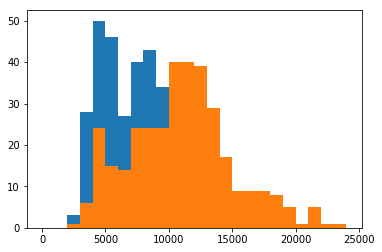

In [38]:
import matplotlib.pyplot as plt
plt.hist(over_75_train['power'], bins = range(0, 25000, 1000));
plt.hist(over_75_test['power'], bins = range(0, 25000, 1000));

In [39]:
bad_data = over_75_train[over_75_train['power'] < 5000]

In [40]:
bad_data.to_csv('ciee_bad_data_raw.csv')

In [41]:
weights = X['weather'] > 75

In [42]:
weights = weights.astype(int) + 1

## Polynomial Ridge Regression

In [46]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)

In [47]:
test_filter = np.array([d in test_days for d in df.index.date])

In [48]:
exclude = np.array([d in exclude_dates for d in df.index.date]) 

In [49]:
X_train, X_test, y_train, y_test = new[~exclude], new[test_filter], y[~exclude], y[test_filter]

In [50]:
from sklearn.linear_model import RidgeCV


In [51]:
model = RidgeCV(alphas=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], normalize=True)

In [52]:
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [53]:
model.alpha_

1e-05

In [54]:
y_pred = model.predict(X_test)

In [55]:
mean_squared_error(y_pred, y_test)

8055383.770363957

In [56]:
np.sqrt(mean_squared_error(y_pred, y_test))

2838.2007981050174

In [57]:
import matplotlib.pyplot as plt

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


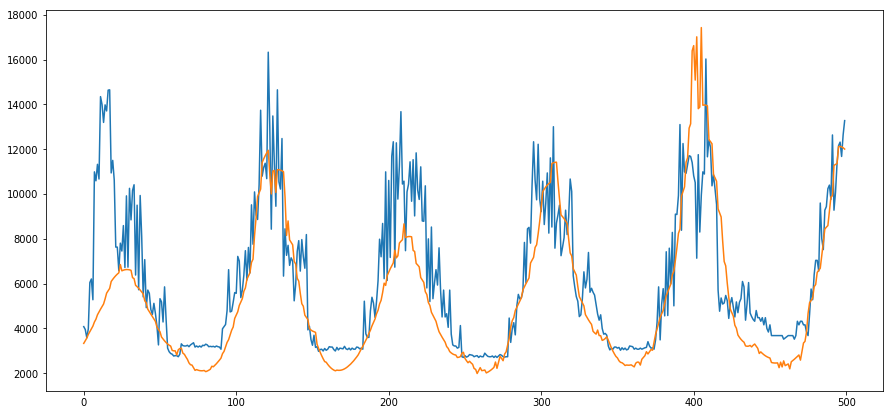

In [58]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

## Random Forest

In [204]:
X.head()

,weather,time_of_year,time_of_week,time_of_day,last_day_power,avg_last_week
2016-06-29 08:00:00-07:00,55.42,15577200.0,201600,28800.0,4080.0,4080.0
2016-06-29 08:15:00-07:00,55.42,15578100.0,202500,29700.0,3952.0,3952.0
2016-06-29 08:30:00-07:00,55.42,15579000.0,203400,30600.0,3584.0,3584.0
2016-06-29 08:45:00-07:00,57.22,15579900.0,204300,31500.0,3984.0,3984.0
2016-06-29 09:00:00-07:00,55.42,15580800.0,205200,32400.0,6048.0,6048.0


In [225]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [276]:
rf = RandomForestRegressor(n_estimators=500, max_features=3, min_impurity_decrease=10)
dt = DecisionTreeRegressor(min_impurity_decrease=100, max_features=3)
adr = AdaBoostRegressor(dt, n_estimators=1000, loss='square')

In [277]:
X_train, X_test, y_train, y_test = X[~exclude], X[test_filter], y[~exclude], y[test_filter]

In [286]:
rf.fit(X_train, y_train)

y_train_pred = adr.predict(X_train)
train_error = np.sqrt(mean_squared_error(y_train_pred, y_train))
print('train error (watts): ', train_error)

y_pred = adr.predict(X_test)
test_error = np.sqrt(mean_squared_error(y_pred, y_test))
print('test error (watts): ', test_error)

train error (watts):  326.271859679475
test error (watts):  2643.483083869406


In [292]:
adr.feature_importances_

array([0.1853592 , 0.17142479, 0.10067109, 0.08144257, 0.19735808,
       0.26374427])

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


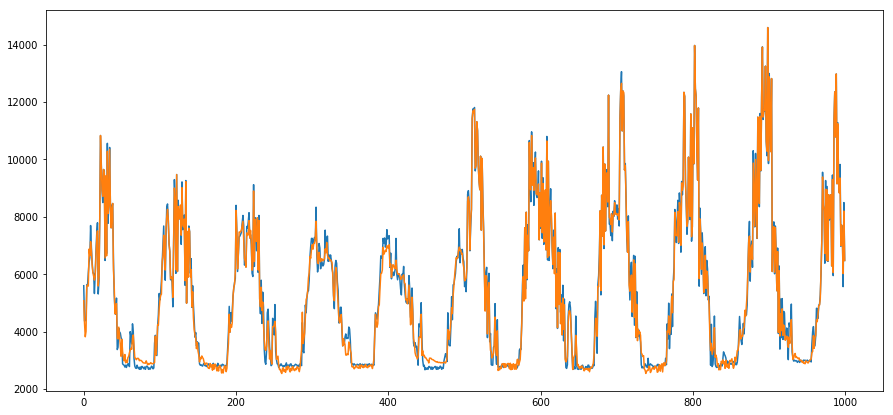

In [288]:
plt.figure(figsize=(15, 7))
plt.plot(range(1000), y_train[:1000])
plt.plot(range(1000), y_train_pred[:1000])

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


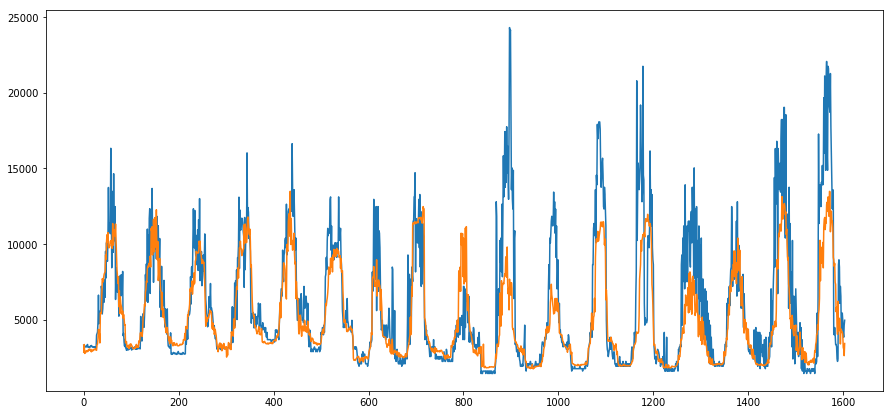

In [289]:
plt.figure(figsize=(15, 7))
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test)), y_pred)

In [290]:
y_test[850:950]

2017-09-11 03:15:00-07:00     1600.0
2017-09-11 03:30:00-07:00     1440.0
2017-09-11 03:45:00-07:00     1600.0
2017-09-11 04:00:00-07:00     1440.0
2017-09-11 04:15:00-07:00     1600.0
2017-09-11 04:30:00-07:00     1440.0
2017-09-11 04:45:00-07:00     1600.0
2017-09-11 05:00:00-07:00     1600.0
2017-09-11 05:15:00-07:00     1440.0
2017-09-11 05:30:00-07:00     1600.0
2017-09-11 05:45:00-07:00     1440.0
2017-09-11 06:00:00-07:00     1440.0
2017-09-11 06:15:00-07:00     1440.0
2017-09-11 06:30:00-07:00     1600.0
2017-09-11 06:45:00-07:00     1600.0
2017-09-11 07:00:00-07:00     1600.0
2017-09-11 07:15:00-07:00     1440.0
2017-09-11 07:30:00-07:00     1920.0
2017-09-11 07:45:00-07:00     2240.0
2017-09-11 08:00:00-07:00    12800.0
2017-09-11 08:15:00-07:00    11840.0
2017-09-11 08:30:00-07:00     3360.0
2017-09-11 08:45:00-07:00     6080.0
2017-09-11 09:00:00-07:00     5280.0
2017-09-11 09:15:00-07:00     7040.0
2017-09-11 09:30:00-07:00     6400.0
2017-09-11 09:45:00-07:00     5920.0
2

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


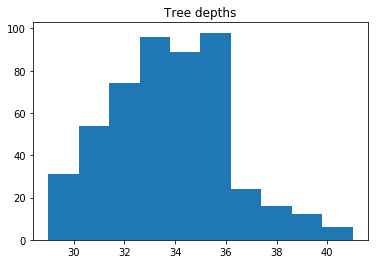

In [291]:
plt.hist([estimator.tree_.max_depth for estimator in rf.estimators_])
plt.title('Tree depths');

In [146]:
all_train = X_train
all_train['power'] = y_train

all_test = X_test
all_test['power'] = y_test

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
all_test['date'] = all_test.index.date

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [159]:
all_test['pred'] = y_pred
all_test['residual'] = y_test - y_pred

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


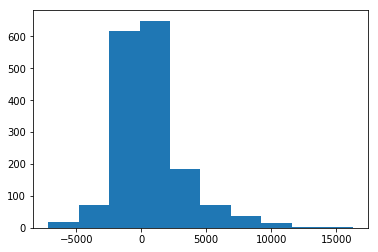

In [162]:
plt.hist(all_test['residual']);

### Splitting Occupied vs. Unoccupied

In [ ]:
start_hour = 9
end_hour = 18

In [ ]:
occupied_mask = (df.index.hour >= start_hour) & (df.index.hour <= end_hour)
occupied_df = df[occupied_mask]
unoccupied_df = df[~occupied_mask]

In [ ]:
# Occupied

X, y = occupied_df.drop(columns=['power', 'date']), occupied_df['power']
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)
exclude = np.array([d in exclude_dates for d in occupied_df.index.date]) 
test_filter = np.array([d in test_days for d in occupied_df.index.date])
X_train, X_test, y_train, y_test= new[~exclude], new[test_filter], y[~exclude], y[test_filter]
model.fit(X_train, y_train)
model.alpha_

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

In [ ]:
# Unoccupied
X, y = unoccupied_df.drop(columns=['power', 'date']), unoccupied_df['power']
poly = PolynomialFeatures(degree=8)
new = poly.fit_transform(X)
exclude = np.array([d in exclude_dates for d in unoccupied_df.index.date]) 
test_filter = np.array([d in test_days for d in unoccupied_df.index.date])
X_train, X_test, y_train, y_test= new[~exclude], new[test_filter], y[~exclude], y[test_filter]
model.fit(X_train, y_train)
model.alpha_

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_pred, y_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

### Try original model with Occupied / Unoccupied

In [ ]:
# Get time of weed
df['time_of_week'] = [get_time_of_week(t) for t in df.index]
indicators = pd.get_dummies(df['time_of_week'])
df = df.merge(indicators, left_index=True, right_index=True)
df = df.drop(labels=['time_of_week'], axis=1)

In [ ]:
# Get temperature cutoffs
cutoffs = [40, 55, 70, 80, 90]
arr = df['weather'].apply(lambda t: get_t_cutoff_values(t, cutoffs)).values
a = np.array(arr.tolist())
t_features = pd.DataFrame(a)
t_features.columns = ['temp_cutoff_' + str(i) for i in cutoffs] + ['max_cutoff']
t_features.index = df.index
df = df.merge(t_features, left_index=True, right_index=True)

In [ ]:
occupied_mask = (df.index.hour >= start_hour) & (df.index.hour <= end_hour)
occupied_df = df[occupied_mask]
unoccupied_df = df[~occupied_mask]

In [ ]:
X, y = df.drop(['power', 'date', 'weather', 'time_of_year', 'time_of_day'], axis=1), df['power']

In [ ]:
# occupied
X, y = occupied_df.drop(columns=['power', 'date', 'weather', 'time_of_year', 'time_of_day']), occupied_df['power']
exclude = np.array([d in exclude_dates for d in occupied_df.index.date]) 
test_filter = np.array([d in test_days for d in occupied_df.index.date])
X_train, X_test, y_train, y_test= X[~exclude], X[test_filter], y[~exclude], y[test_filter]
model = RidgeCV(normalize=True, alphas=alphas)
model.fit(X_train, y_train)
model.alpha_

In [ ]:
y_pred = model.predict(X_test)
mean_squared_error(y_pred, y_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

In [ ]:
# occupied
X, y = unoccupied_df.drop(columns=['power', 'date', 'time_of_year', 'time_of_day', 'temp_cutoff_40', 'temp_cutoff_50', 'temp_cutoff_60', 'temp_cutoff_70', 'temp_cutoff_80', 'max_cutoff']), unoccupied_df['power']
exclude = np.array([d in exclude_dates for d in unoccupied_df.index.date]) 
test_filter = np.array([d in test_days for d in unoccupied_df.index.date])
X_train, X_test, y_train, y_test= X[~exclude], X[test_filter], y[~exclude], y[test_filter]
model = RidgeCV(normalize=True, alphas=alphas)
model.fit(X_train, y_train)
model.alpha_

In [ ]:
y_pred = model.predict(X_test)
mean_squared_error(y_pred, y_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(500), y_test[:500])
plt.plot(range(500), y_pred[:500])

### Finding better intervals

In [ ]:
simple = df[['power', 'weather']]
simple.head()

In [ ]:
simple['floor'] = np.floor_divide(df['weather'], 5)

In [ ]:
median_powers = simple.groupby('floor').median()['power']

In [ ]:
mean_powers = simple.groupby('floor').mean()['power']

In [ ]:
plt.plot(median_powers.index, median_powers, label='median')
plt.plot(mean_powers.index, mean_powers, label='mean')
plt.legend()